In [16]:
% setup environment
% clear data and number format
clear; format short e
% set path to equilibrium solver
txt=pwd; n=length(txt); rootpath=txt;
n=strfind(rootpath,"USERS"); rootpath=txt(1:n-2);
PHREEQCpath=[rootpath,'/runPHREEQC'];
addpath(PHREEQCpath);
JEQUILIBpath=[rootpath,'/JEQUILIB'];
addpath(JEQUILIBpath);
% turn off warnings
warning off
%graphics_toolkit ("notebook"); 
graphics_toolkit ("plotly"); 
%graphics_toolkit("gnuplot")
% delete phreeqcrunfile
%system("rm porttest.txt");

# basic kinetic model

This page about PHREEQC describes a general way to do kinetic modelling.  I decided to use this method for the precipitation of calcite, dissolution of portlandite and the dissolution of carbon dioxide gas.  It is simplest to use the same model to describe all processes.  It will describe either precipitation or dissolution depending on the magnitude of the saturation index (IAP/Ksp) compared to 1, where 1 means at equilibrium.

https://wwwbrr.cr.usgs.gov/projects/GWC_coupled/phreeqc/html/final-20.html

$$rate = k*\left(1-\left(\dfrac{IAP}{K_{sp}}\right)^\sigma\right)$$

The rate constant $k$ is an adjustable parameter and $IAP$ is formulated the same was as $K_{sp}$ but using the actual concentrations and not necessarily at equilibrium.  The ratio (IAP/Ksp) is also referred to as the saturation index.  The exponent $\sigma$ is often set equal to 1 but can be used as an adjustable parameter to improve data fitting if necessary.

An additional term for the amount of solid present is used by Mbamba et al. (2015).  A section of this paper (2.5.2 Precipitation: Simple kinetics) describes the approach used (including citations to background literature).

https://www.sciencedirect.com/science/article/abs/pii/S0043135414007064?via%3Dihub

so the rate will be faster when there is more solid present where the concentration of solid is indicated by $X$.

Kazadi Mbamba C, Tait S, Flores-Alsina X, Batstone DJ. A systematic study of multiple minerals precipitation modelling in wastewater treatment. Water Res. 2015 Nov 15;85:359-70. doi: 10.1016/j.watres.2015.08.041. Epub 2015 Aug 28. 

$$rate = k*X*\left(1-\left(\dfrac{IAP}{K_{sp}}\right)^\sigma\right)$$

# model portlandite dissolution kinetics

follow the example [here](https://phreeqcusers.org/index.php?topic=1137.0) for calcite but replace with portlandite and the kinetic equation of the form 

$$\dfrac{d(portlandite)}{dt} = k_P X_P \left(1-\left(\dfrac{IAP_P}{Ksp_P}\right)\right)$$

$$ \mathrm{Ca(OH)_2}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + 2\mathrm{OH^{-}}$$

$$K_{spP} = [\mathrm{Ca^{2+}}][\mathrm{OH^{-}}]^2$$

need to use llnl database because it has portlandite in it.  The mineral phase can precipitate or dissolve but starts in excess so dissolves.

# model calcite precipitation kinetics

$$\dfrac{d(calcite)}{dt} = k_C X_C \left(1-\left(\dfrac{IAP_C}{Ksp_C}\right)\right)$$

$$ \mathrm{Ca(CO_3)}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + \mathrm{CO_3^{2-}}$$

$$K_{spC} = [\mathrm{Ca^{2+}}][\mathrm{CO_3^{2-}}]$$

# model CO2 dissolution kinetics

follow the example [here](https://phreeqcusers.org/index.php?topic=2260.0).  Also typed up as a script in this directory as CO2parhurst.ipynb.  And a modified version CO2parkhurstMODIFIED.ipynb  The version in Parkhurst's post assumed the wrong form of the gas exchange reaction in the database.  It assumed CO2(aq) formed as a discrete species but the database does not include that species it includes H2CO3 plus CO2(aq).

Using "Henry's Law" corresponds to the reaction in the LLNL database

$$CO_2(g)+H_2O=HCO_3^-+H^+$$
so 
$$K_H = \dfrac{[HCO_3^-][H^+]}{P_{CO2}}$$
so
$$[HCO_3^-]_{eq}=\dfrac{K_H*P_{CO2}}{[H^+]}$$

This is the value of bicarbonate in equilibrium with the specified PCO2 of carbon dioxide (typically 10$^{-3.5}$atm).  Instead of comparing to the IAP as in the mineral reactions we can compare to the bicarbonate concentration calculated by PHREEQC at each time step.  So the rate will be faster the further we are from equilibrium.  At eacth time step the $[HCO3]$ should be lower than the equilibrium amount so the ratio will be less than zero and the rate will be positive ... but if the pH drops and $[HCO3]$ is too high then the solution should degas.

$$rate = k * \left(1-\left(\dfrac{[HCO3]_{PHREEQC}}{[HCO3]_{eq}}\right)\right)$$

A term could be added in for the concentration of bicarbonate (analogous to X for solids) but I am not sure why that would make sense.  This could be a further revision if necessary in the future.


In [17]:
database=['llnl.dat'];

# Variables 

These are the default values I wrote this script with.  The next cell you can change them.

XP=0.1 mol/L.  the initial amount of portlandite. should be a big number.

XC=1e-6 mol/L.  seed crystal amount (if zero then won't ever ppte because multiplication by zero).  1e-6 value from that paper from Australia.

kP=1e-5. just set as an arbitrary value.  need data to help figure out a reasonable value.

kC=1e-4. just set as an arbitrary value. need data to help figure out a  reasonable value.  makes sense to be faster than dissolution?

logPCO2=-3.5

kCO2=8.5e-7.  I picked a value that CO2 would go in slow enough. too fast and it just looks like the CO2 equilbirated model I made before.  (and show as a blue line in the graph below).



In [18]:
% variables

XP=0.135; XPstr=num2str(XP);
XC=1e-6; XCstr=num2str(XC);
kP=1e-5; kPstr=num2str(kP);
kC=1e-4; kCstr=num2str(kC);
logPCO2=-3.5; logPCO2str=num2str(logPCO2);
kCO2=8.5e-7; kCO2str=num2str(kCO2);
logtime=1:0.1:5; time=10.^logtime;

In [19]:
solutionboxtext=[...
{'SOLUTION 1\n'}
{'       pe      13.75\n'}
{'       pH      7\n'}
{'       temp    25\n'}
{'-units mol/kgw\n'}
   ];
[nolinesSOLN,length]=size(solutionboxtext);

In [20]:
%equilibboxtext=[...
%{'EQUILIBRIUM_PHASES 1\n'}
%{'CO2(g)   -3.5\n'}
%   ];
%[nolinesEQUIL,length]=size(equilibboxtext);

In [21]:
rateboxtext=[...
{'RATES\n'}
{'Portlandite\n'}
{'-start\n'}
{'1   REM   PARM(1) = rate constant\n'}
{'10  si_pp = SI("Portlandite")\n'}
{'20  IF (M <= 0  and si_pp < 0) THEN GOTO 200\n'}
{'120 rate = PARM(1) *M* (1 - 10^(si_pp))\n'}
{'140 moles = rate*TIME\n'}
{'200 SAVE moles\n'}
{'   -end\n'}
{'Calcite\n'}
{'-start\n'}
{'1   REM   PARM(1) = rate constant\n'}
{'10  si_cc = SI("Calcite")\n'}
{'20  IF (M <= 0  and si_cc < 0) THEN GOTO 200\n'}
{'120 rate = PARM(1) *M* (1 - 10^(si_cc))\n'}
{'140 moles = rate*TIME\n'}
{'200 SAVE moles\n'}
{'   -end\n'}
{'CO2_dissolution\n'}
{'-start\n'}
{'20 k = parm(2)\n'}
{'30 eq_HCO3 = 10^PARM(1)*10^LK_PHASE("CO2(g)")/ACT("H+")\n'}
{'40 act_HCO3 = ACT("HCO3-")\n'}
{'50 moles = k * (1-(act_HCO3/eq_HCO3)) * TIME\n'}
{'60 SAVE moles\n'}
{'   -end\n'}
];
[nolinesRATE,length]=size(rateboxtext);

In [22]:
m0Pline=['  -m0    ',XPstr,'\n'];
mPline=['  -m    ',XPstr,'\n'];
parmsPline=['  -parms ',kPstr,'\n'];
m0Cline=['  -m0    ',XCstr,'\n'];
mCline=['  -m    ',XCstr,'\n'];
parmsCline=['  -parms ',kCstr,'\n'];
parmsCO2line=['  -parms ',logPCO2str,' ',kCO2str,'\n'];
timestr=mat2str([0 time]); timestr = regexprep(timestr,'\[','');  timestr = regexprep(timestr,'\]','');
timeline=[' -steps ',timestr,' s\n'];

kineticsboxtext=[...
{'KINETICS 1\n'}
{'Portlandite\n'}
{'  -tol   1e-13\n'}
{m0Pline}
{mPline}
{parmsPline}
{'Calcite\n'}
{'  -tol   1e-13\n'}
{m0Cline}
{mCline}
{parmsCline}
{'CO2_dissolution\n'}
{'  -tol   1e-13\n'}
{'-formula CO2 1\n'}
{parmsCO2line}
{timeline}
{'  -cvode\n'}
{'-runge_kutta      6\n'}
];
[nolinesKIN,length]=size(kineticsboxtext);

In [23]:
selectboxtext=[...
{' SELECTED_OUTPUT\n'}
{' -file portout.txt\n'}
{' -selected_out true\n'}
{' -user_punch true\n'}
{' -high_precision true\n'}
{' -reset false\n'}
{' -simulation false\n'}
{' -state false\n'}
{' -distance false\n'}
{' -time false\n'}
{' -step false\n'}
{' -ph false\n'}
{' -pe false\n'}
{' -reaction false\n'}
{' -temperature false\n'}
{' -alkalinity false\n'}
{' -ionic_strength false\n'}
{' -water false\n'}
{' -charge_balance false\n'}
{' -percent_error false\n'}
%{' -molalities H+ Ca+2  \n'}
%{' -equilibrium_phases CO2(g)  \n'}
];
[nolinesSEL,length]=size(selectboxtext);

In [24]:
punchboxtext=[...
{'USER_PUNCH\n'}
{'        -headings seconds  Ca  pH Calcite  Portlandite \n'}
{'  10 PUNCH SIM_TIME, TOT("Ca"), -LA("H+"), KIN("Calcite"), KIN("Portlandite") \n'}
];
[nolinesPUNCH,length]=size(punchboxtext);

In [25]:
fileID=fopen('porttest.txt','w');

fprintf(fileID,'TITLE TEST PORTLANDITE DISSOLUTION\n');

for i=1:nolinesSOLN
    line=cell2mat(solutionboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
%for i=1:nolinesEQUIL
%    line=cell2mat(equilibboxtext(i,:));
%    fprintf(fileID,line)
%end
%fprintf(fileID,'\n');
for i=1:nolinesRATE
    line=cell2mat(rateboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesKIN
    line=cell2mat(kineticsboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesSEL
    line=cell2mat(selectboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesPUNCH
    line=cell2mat(punchboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
fprintf(fileID,'END');
fclose(fileID);

In [26]:
str=['system("phreeqc porttest.txt out.txt ', database,'");'];
eval(str); % output to the screen
%evalc(str); % so no screen output
fid = fopen('portout.txt','rt');
hdr = strtrim(regexp(fgetl(fid),'\t','split'));
hdr=hdr(1:5)';
mat = cell2mat(textscan(fid,repmat('%f',1,numel(hdr))));
[nsize,msize]=size(mat);
time=mat(2:nsize,1); Caphreeqc=mat(2:nsize,2); pHphreeqc=mat(2:nsize,3);
calcitephreeqc=mat(2:nsize,4); portlanditephreeqc=mat(2:nsize,5);

# also solve with the ODE solver

In [27]:
function [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca,Kw,KH,Ka1,Ka2,PCO2)

a=1; b=2*Ca; c=-KH*Ka1*PCO2-Kw; d=-2*KH*Ka1*Ka2*PCO2;
H=roots([a b c d]);
H=H(imag(H)==0); %sets any imaginary roots to zero
% display the positive real root
H=H(H>0);
%solve speciation
H2CO3=KH*PCO2; HCO3=(KH*PCO2*Ka1)/H; CO3=(KH*PCO2*Ka1*Ka2)/(H^2); OH=Kw/H;

end

In [28]:
% try with ode solver.  first need to define the function

function dCdt=dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspC,KspP,kC,kP)

[H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(C(3),Kw,KH,Ka1,Ka2,PCO2);

IAPP=C(3)*OH^2; IAPC=C(3)*CO3;

dCdt=zeros(3,1); % top entry is [portlandite].  bottom entry is [calcium cation].  middle is calcite conc

% the three entries for the 3 rates. 

%rate of decrease in portlandite concentration.  IAP/Ksp is less than 1 so rate is negative
dCdt(1)=kP*C(1)*(IAPP/KspP-1);  

%rate of formation of calcite
if IAPC/KspC >1; dCdt(2)=C(2)*kC*(((IAPC/KspC-1))); end

%rate of increase in calcium concentration from port dissolve and decrease Ca from calcite ppte
dCdt(3)=-kP*C(1)*(IAPP/KspP-1)-C(2)*kC*(IAPC/KspC-1);  

dC=dCdt;


end

In [29]:
% make an anonymous function because ODE solver only wants conc and time as variables
% and dfine all the constants too

%Kw=1e-14; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; PCO2=10^-3.5; KspC=3.4e-9; KspC=1.4e-8;
%KspP=5.5e-6; kC=1e-4; kP=1e-6;

Kw=1e-14; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; PCO2=10^-3.5; KspC=3.4e-9; %KspC=1.4e-8;
KspP=5.5e-6; KspP=3.5645e-6;
kC=1e-4; kP=1e-5;

dCdtrate = @(t,C)dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspC,KspP,kC,kP);

%[value]=dCdtrate(0,[0.2 1e-9 1e-1]);


 = red phreeqc blue ODE


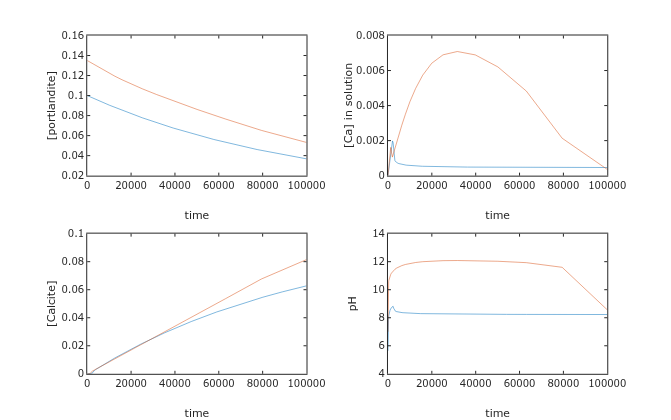

ERROR: received unknown message
Message type: usage_request


In [30]:
display('red phreeqc blue ODE')

% call ODE solver

[t, C]=ode45(dCdtrate,[0 100000],[0.1 1e-6 0]);

port=C(:,1); %portlandite left over
calcite=C(:,2); %Calcite formed
Ca=C(:,3); %Ca
pH=[]; % pH reset

for i=1:size(Ca,1)
    [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca(i),Kw,KH,Ka1,Ka2,PCO2);
    pH(i)=-log10(H);
end

subplot(221); plot(t,port,time,portlanditephreeqc); ylabel('[portlandite]'); xlabel('time')
subplot(222); plot(t,Ca,time,Caphreeqc); ylabel('[Ca] in solution'); xlabel('time')
subplot(223); plot(t,calcite,time,calcitephreeqc); ylabel('[Calcite]'); xlabel('time')
subplot(224); plot(t,pH,time,pHphreeqc); ylabel('pH'); xlabel('time')

